In [1]:
import os

os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"

import torch
from matplotlib import pyplot as plt
from internal.dataparsers.matrix_city_dataparser import MatrixCity, MatrixCityDataParser

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
dataset_path = os.path.expanduser("~/data-extra/MatrixCity/small_city-self_render/aerial/")
dataset_path

'/home/zhensheng/data-extra/MatrixCity/small_city-self_render/aerial/'

In [3]:
train_transforms_json_list = []
test_transforms_json_list = []
for dir in os.scandir(dataset_path):
    if dir.is_dir() is False:
        continue

    target_list = train_transforms_json_list
    if dir.name.endswith("_test") is True:
        target_list = test_transforms_json_list

    assert os.path.exists(os.path.join(dir.path, "transforms_origin.json"))
    target_list.append(os.path.join(dir.name, "transforms_origin.json"))

# train_transforms_json_list = [
#     "block_1/transforms_origin.json",
#     "block_2/transforms_origin.json",
# ]
# test_transforms_json_list = [
#     "block_1_test/transforms_origin.json"
# ]

train_transforms_json_list, test_transforms_json_list

(['block_7/transforms_origin.json',
  'block_4/transforms_origin.json',
  'block_2/transforms_origin.json',
  'block_6/transforms_origin.json',
  'block_10/transforms_origin.json',
  'block_1/transforms_origin.json',
  'block_3/transforms_origin.json',
  'block_5/transforms_origin.json',
  'block_9/transforms_origin.json',
  'block_8/transforms_origin.json'],
 ['block_10_test/transforms_origin.json',
  'block_8_test/transforms_origin.json',
  'block_4_test/transforms_origin.json',
  'block_9_test/transforms_origin.json',
  'block_3_test/transforms_origin.json',
  'block_5_test/transforms_origin.json',
  'block_6_test/transforms_origin.json',
  'block_7_test/transforms_origin.json',
  'block_2_test/transforms_origin.json',
  'block_1_test/transforms_origin.json'])

In [4]:
dataparser = MatrixCity(
    depth_read_step=8,
).instantiate(
    path=dataset_path,
    output_path=os.path.abspath(""),
    global_rank=0,
)
dataparser

In [5]:
train_image_set, point_cloud = dataparser._parse_json(train_transforms_json_list, build_point_cloud=True)
test_image_set, _ = dataparser._parse_json(test_transforms_json_list, build_point_cloud=False)
train_image_set.cameras.camera_center, test_image_set.cameras.camera_center, point_cloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
{
    "train": [
        "block_7/transforms_origin.json",
        "block_4/transforms_origin.json",
        "block_2/transforms_origin.json",
        "block_6/transforms_origin.json",
        "block_10/transforms_origin.json",
        "block_1/transforms_origin.json",
        "block_3/transforms_origin.json",
        "block_5/transforms_origin.json",
        "block_9/transforms_origin.json",
        "block_8/transforms_origin.json"
    ],
    "scale": 0.01,
    "depth_scale": 0.01,
    "max_depth": 65000,
    "depth_read_step": 1,
    "max_points": 3840000
}


(tensor([[ 6.4000, -1.2000,  3.5000],
         [ 6.4000, -1.5923,  3.5000],
         [ 6.4000, -1.9846,  3.5000],
         ...,
         [ 8.7000, -0.6000,  3.5000],
         [ 8.7000, -0.9000,  3.5000],
         [ 8.7000, -1.2000,  3.5000]]),
 tensor([[-5.9000,  5.9000,  2.0000],
         [-5.9000,  5.5000,  2.0000],
         [-5.9000,  5.1000,  2.0000],
         ...,
         [-1.7000, -2.5000,  1.5000],
         [-1.7000, -2.9000,  1.5000],
         [-1.7000, -3.3000,  1.5000]]),
 PointCloud(xyz=array([[ 8.707018  , -1.78871316, -0.030717  ],
        [ 8.79676414, -1.80783054, -0.03063295],
        [ 7.65148334, -0.99065616,  0.01019697],
        ...,
        [ 9.03241737,  0.27357651, -0.03154939],
        [ 7.84517393,  1.76985255, -0.03231362],
        [ 8.94975143,  0.45207608, -0.03195389]]), rgb=array([[ 66,  75,  90],
        [ 65,  75,  88],
        [103, 106, 118],
        ...,
        [ 67,  76,  90],
        [ 63,  70,  86],
        [ 67,  76,  91]], dtype=uint8)))

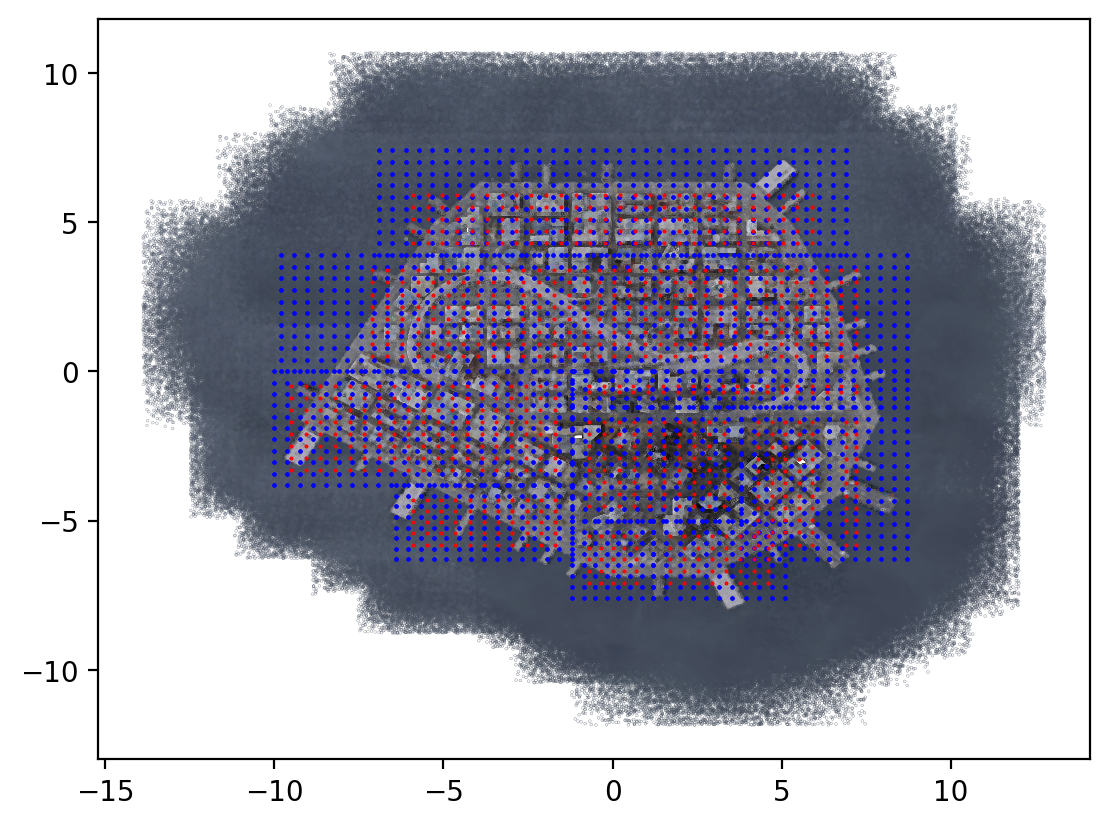

In [35]:
train_camera_centers = train_image_set.cameras.camera_center.cpu().numpy()
test_camera_centers = test_image_set.cameras.camera_center.cpu().numpy()

fig, ax = plt.subplots()
ax.scatter(point_cloud.xyz[:, 0], point_cloud.xyz[:, 1], c=point_cloud.rgb / 255., s=0.01)
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2, c="blue")
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
plt.show()

In [7]:
scene_center = torch.tensor([0., 0., 0.])  # scene center does not locate in the partition center, it is the corner
partition_radius = 1.8
torch.set_printoptions(precision=16)

In [8]:
# find scene bounding box
xyz_min = torch.min(train_image_set.cameras.camera_center, dim=0)[0]
xyz_max = torch.max(train_image_set.cameras.camera_center, dim=0)[0]
xyz_min, xyz_max

(tensor([-10.0000009536743164,  -7.6000013351440430,   1.4999991655349731]),
 tensor([8.7000007629394531, 7.4000005722045898, 5.0000019073486328]))

In [9]:
# make bounding box align with the center one
def align_border(xyz):
    xyz_radius_factor = (xyz - scene_center) / (2 * partition_radius)
    xyz_ceil_radius_factor = torch.ceil(torch.abs(xyz_radius_factor)) * torch.sign(xyz_radius_factor)
    new_xyz = scene_center + xyz_ceil_radius_factor * 2 * partition_radius
    # xyz_min_radius_factor, xyz_min_ceil_radius_factor, new_xyz_min
    return new_xyz


partition_xyz_min = align_border(xyz_min)
partition_xyz_max = align_border(xyz_max)
partition_xyz_min, partition_xyz_max

(tensor([-10.7999992370605469, -10.7999992370605469,   3.5999999046325684]),
 tensor([10.7999992370605469, 10.7999992370605469,  7.1999998092651367]))

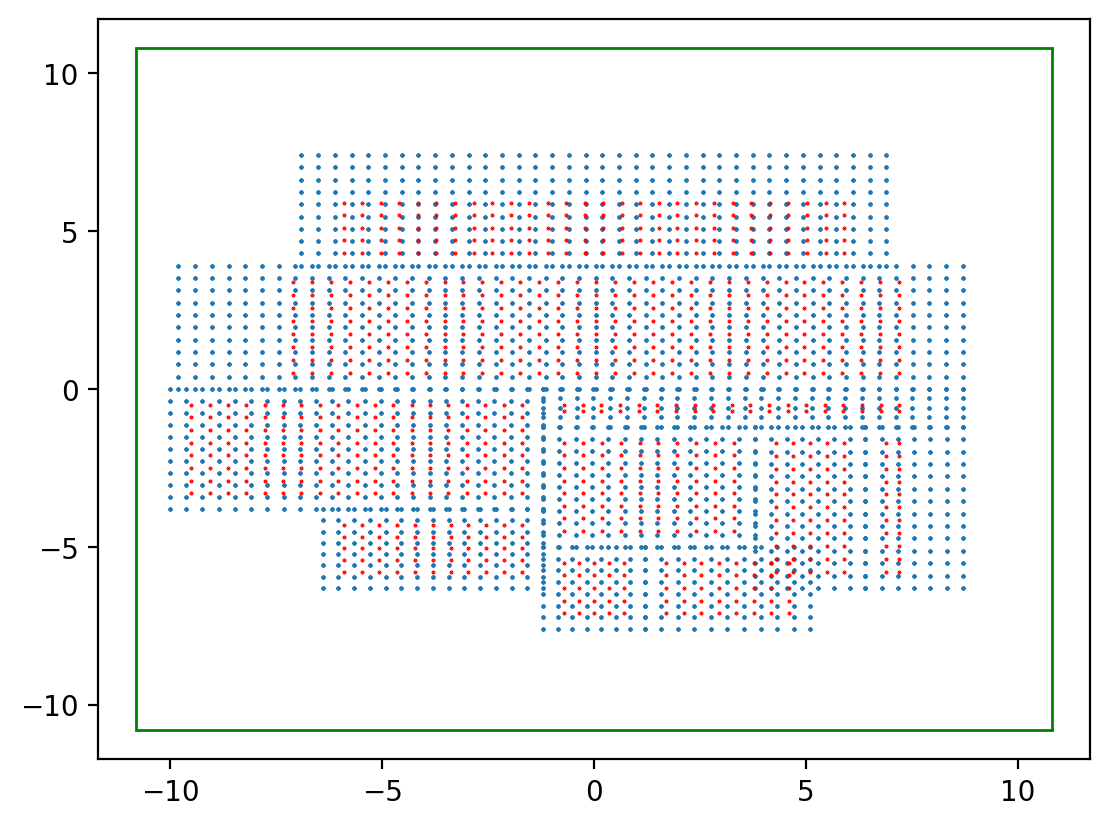

In [10]:
import matplotlib.patches as mpatches

plt.close()
fig, ax = plt.subplots()
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2)
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
ax.add_artist(mpatches.Rectangle(
    (partition_xyz_min[0], partition_xyz_min[1]),
    partition_xyz_max[0] - partition_xyz_min[0],
    partition_xyz_max[1] - partition_xyz_min[1],
    fill=False,
    color="green",
))
ax.set_xlim([partition_xyz_min[0] - 0.5 * partition_radius, partition_xyz_max[0] + 0.5 * partition_radius])
ax.set_ylim([partition_xyz_min[1] - 0.5 * partition_radius, partition_xyz_max[1] + 0.5 * partition_radius])
plt.show(fig)

In [11]:
# sometimes float division may not produce perfect integer, use torch.ceil() to make sure that all image are covered
partition_count = torch.ceil(((partition_xyz_max - partition_xyz_min) / (2 * partition_radius))).to(torch.int)
partition_count

tensor([6, 6, 1], dtype=torch.int32)

In [12]:
center_partition_offset = (
        torch.ceil((torch.abs(partition_xyz_min) / (2 * partition_radius))) * torch.sign(partition_xyz_min)).to(
    torch.int)
# center_partition_offset
grid_x, grid_y = torch.meshgrid(
    torch.arange(partition_count[0], dtype=torch.int) + center_partition_offset[0],
    torch.arange(partition_count[1], dtype=torch.int) + center_partition_offset[1],
    indexing="ij",
)
grid_x, grid_y  # build continuous grid coordinate for partitions, scene center is (0, 0)

(tensor([[-3, -3, -3, -3, -3, -3],
         [-2, -2, -2, -2, -2, -2],
         [-1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0,  0],
         [ 1,  1,  1,  1,  1,  1],
         [ 2,  2,  2,  2,  2,  2]], dtype=torch.int32),
 tensor([[-3, -2, -1,  0,  1,  2],
         [-3, -2, -1,  0,  1,  2],
         [-3, -2, -1,  0,  1,  2],
         [-3, -2, -1,  0,  1,  2],
         [-3, -2, -1,  0,  1,  2],
         [-3, -2, -1,  0,  1,  2]], dtype=torch.int32))

In [13]:
partition_xys = []  # bottom-left
partition_grid_xy = []
for i in range(partition_count[0]):
    for j in range(partition_count[1]):
        partition_xys.append(partition_xyz_min[:2] + torch.tensor([i * 2 * partition_radius, j * 2 * partition_radius]))
        partition_grid_xy.append((grid_x[i, j].item(), grid_y[i, j].item()))
# partition_xys = torch.stack(partition_xys)
partition_xys, partition_grid_xy

([tensor([-10.7999992370605469, -10.7999992370605469]),
  tensor([-10.7999992370605469,  -7.1999993324279785]),
  tensor([-10.7999992370605469,  -3.5999994277954102]),
  tensor([-1.0799999237060547e+01,  9.5367431640625000e-07]),
  tensor([-10.7999992370605469,   3.6000003814697266]),
  tensor([-10.7999992370605469,   7.2000007629394531]),
  tensor([ -7.1999993324279785, -10.7999992370605469]),
  tensor([-7.1999993324279785, -7.1999993324279785]),
  tensor([-7.1999993324279785, -3.5999994277954102]),
  tensor([-7.1999993324279785e+00,  9.5367431640625000e-07]),
  tensor([-7.1999993324279785,  3.6000003814697266]),
  tensor([-7.1999993324279785,  7.2000007629394531]),
  tensor([ -3.5999994277954102, -10.7999992370605469]),
  tensor([-3.5999994277954102, -7.1999993324279785]),
  tensor([-3.5999994277954102, -3.5999994277954102]),
  tensor([-3.5999994277954102e+00,  9.5367431640625000e-07]),
  tensor([-3.5999994277954102,  3.6000003814697266]),
  tensor([-3.5999994277954102,  7.2000007629

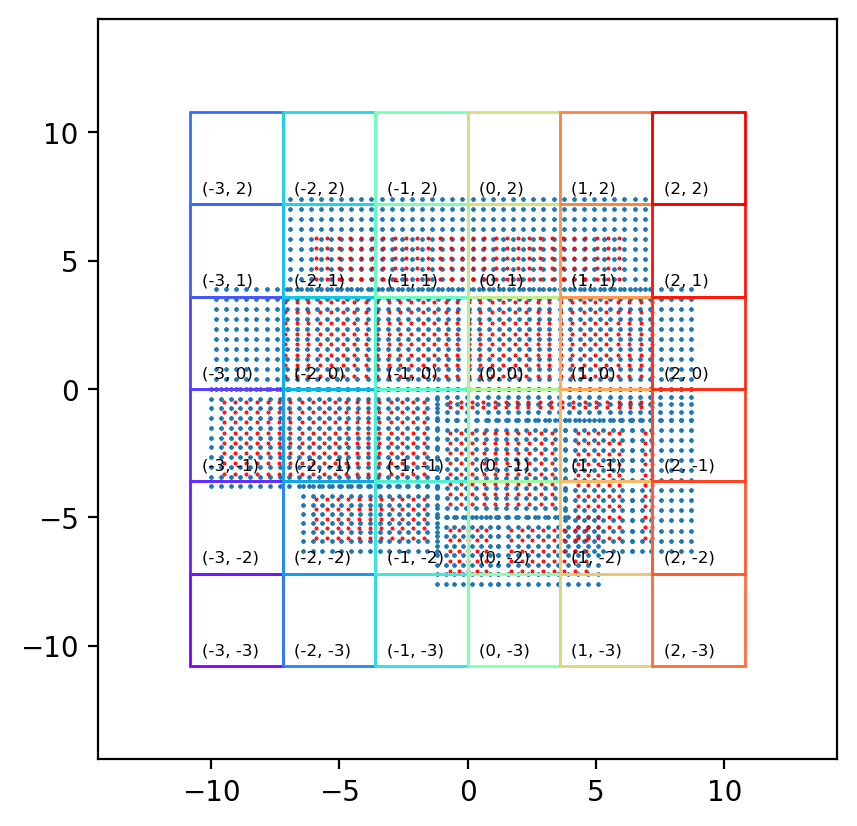

In [36]:
plt.close()
from matplotlib.pyplot import cm
import numpy as np

colors = list(iter(cm.rainbow(np.linspace(0, 1, len(partition_xys)))))
fig, ax = plt.subplots()
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2)
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
ax.set_xlim([partition_xyz_min[0] - 2 * partition_radius, partition_xyz_max[0] + 2 * partition_radius])
ax.set_ylim([partition_xyz_min[1] - 2 * partition_radius, partition_xyz_max[1] + 2 * partition_radius])
ax.set_aspect('equal', adjustable='box')

for idx, i in enumerate(partition_xys):
    ax.add_artist(mpatches.Rectangle(
        (i[0], i[1]),
        2 * partition_radius,
        2 * partition_radius,
        fill=False,
        color=colors[idx],
    ))
    ax.annotate("({}, {})".format(*partition_grid_xy[idx]),
                xy=(i[0] + 0.25 * partition_radius, i[1] + 0.25 * partition_radius), fontsize=6)

plt.show(fig)

In [15]:
is_image_in_partition_mask_list = []
is_image_see_partition_mask_list = []
partition_image_indices_list = []
enlarge = 0.2


def is_image_in_bounding_box(xy_min, xy_max):
    x_in_bounding_box = torch.logical_and(
        torch.ge(train_image_set.cameras.camera_center[:, 0], xy_min[0]),
        torch.le(train_image_set.cameras.camera_center[:, 0], xy_max[0]),
    )
    y_in_bounding_box = torch.logical_and(
        torch.ge(train_image_set.cameras.camera_center[:, 1], xy_min[1]),
        torch.le(train_image_set.cameras.camera_center[:, 1], xy_max[1]),
    )
    return torch.logical_and(x_in_bounding_box, y_in_bounding_box)


os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import cv2


def read_depth(path: str, scale: float):
    return cv2.imread(
        path,
        cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH,
    )[..., 0] * scale


def read_rgb(path: str):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def get_image_point_cloud(frame_idx):
    ds_factor = 4

    pt_path = os.path.join("points", "{:05d}.pt".format(frame_idx))
    if os.path.exists(pt_path) is True:
        return torch.load(pt_path)
    else:
        cameras = train_image_set.cameras
        params = dataparser.params
        frame_idx = frame_idx * params.depth_read_step
        # build intrinsics matrix
        fx = cameras.fx[frame_idx] / ds_factor
        fy = cameras.fy[frame_idx] / ds_factor
        cx = cameras.cx[frame_idx] / ds_factor
        cy = cameras.cy[frame_idx] / ds_factor
        K = np.eye(3)
        K[0, 2] = cx
        K[1, 2] = cy
        K[0, 0] = fx
        K[1, 1] = fy

        # build pixel coordination
        width = int(cameras.width[frame_idx]) // ds_factor
        height = int(cameras.height[frame_idx]) // ds_factor
        image_pixel_count = width * height
        u_coord = np.tile(np.arange(width), (height, 1)).reshape(image_pixel_count)
        v_coord = np.tile(np.arange(height), (width, 1)).T.reshape(image_pixel_count)
        p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)]).T
        homogenous_coordinate = np.matmul(p2d, np.linalg.inv(K).T)

        # read rgb and depth
        depth_paths = train_image_set.depth_paths
        depth = read_depth(depth_paths[frame_idx], params.scale * params.depth_scale)
        depth = cv2.resize(depth, (width, height), interpolation=cv2.INTER_NEAREST).reshape((-1,))

        # discard invalid depth
        valid_depth_indices = np.where(depth < params.max_depth * params.scale * params.depth_scale)
        depth = depth[valid_depth_indices]
        homogenous_coordinate = homogenous_coordinate[valid_depth_indices]

        # convert to world coordination
        points_3d_in_camera = homogenous_coordinate * depth[:, None]
        points_3d_in_camera[:, 1] *= -1
        points_3d_in_camera[:, 2] *= -1
        image_c2w = torch.linalg.inv(train_image_set.cameras[frame_idx].world_to_camera.T)
        image_c2w[:3, 1:3] *= -1
        points = torch.matmul(
            torch.tensor(points_3d_in_camera, dtype=torch.float),
            image_c2w[:3, :3].T,
        ) + image_c2w[:3, 3]
        os.makedirs(os.path.dirname(pt_path), exist_ok=True)
        torch.save(points, pt_path)
        return points


from tqdm.auto import tqdm


def is_points_inside_bounding_box(xy: torch.Tensor, xy_min: torch.Tensor, xy_max: torch.Tensor):
    is_x_or_y_inside = torch.logical_and(
        torch.ge(xy, xy_min),
        torch.le(xy, xy_max),
    )
    return torch.logical_and(is_x_or_y_inside[:, 0], is_x_or_y_inside[:, 1])


def is_image_see_bounding_box(
        in_bbox_mask,
        xy_min,
        xy_max,
        search_bbox_enlarge_ratio: float = 1.,
        threshold: float = 0.25,
):
    """
    :param in_bbox_mask: 
    :param xy_min: 
    :param xy_max: 
    :param search_bbox_enlarge_ratio: 
    :param threshold: points_in_bounding_box/all_points > threshold, image will be added
    :return: 
    """

    # build enlarged bounding box
    xy_min_search = xy_min - search_bbox_enlarge_ratio * partition_radius
    xy_max_search = xy_max + search_bbox_enlarge_ratio * partition_radius
    # find images inside enlarged bounding box
    is_image_in_enlarged_bbox_mask = is_image_in_bounding_box(xy_min_search, xy_max_search)
    # exclude images inside original bounding box
    searchable_image_mask = torch.logical_and(is_image_in_enlarged_bbox_mask, torch.logical_not(in_bbox_mask))
    searchable_image_indices = torch.nonzero(searchable_image_mask).squeeze(-1).numpy().tolist()
    # calculate the percentage of the points that inside bounding box
    final_mask = torch.zeros_like(searchable_image_mask, dtype=torch.bool)
    for image_index in tqdm(searchable_image_indices, leave=False, desc="searching out-of-bbox images"):
        pc = get_image_point_cloud(image_index)
        inside_mask = is_points_inside_bounding_box(pc[:, :2], xy_min, xy_max)
        ratio = inside_mask.sum() / pc.shape[0]
        # add to list if >= threshold
        if ratio >= threshold:
            final_mask[image_index] = True
    # print("found: {}".format(searchable_image_indices.shape))
    return final_mask


for i in tqdm(partition_xys):
    xy_min = i
    xy_max = i + 2 * partition_radius
    xy_min_enlarged = i - enlarge * partition_radius
    xy_max_enlarged = i + (2 + enlarge) * partition_radius

    is_image_in_partition = is_image_in_bounding_box(xy_min, xy_max)
    is_image_see_partition = torch.zeros_like(is_image_in_partition)
    # only apply enlarging if it contains images
    if is_image_in_partition.sum().item() != 0:
        is_image_in_partition = is_image_in_bounding_box(xy_min_enlarged, xy_max_enlarged)
        is_image_see_partition = is_image_see_bounding_box(is_image_in_partition, xy_min, xy_max)
    is_image_in_partition_mask_list.append(is_image_in_partition)
    is_image_see_partition_mask_list.append(is_image_see_partition)
    image_indices = torch.nonzero(torch.logical_or(is_image_in_partition, is_image_see_partition)).squeeze(-1)
    partition_image_indices_list.append(image_indices)

is_image_in_partition_mask_list, partition_image_indices_list, [i.sum() for i in is_image_in_partition_mask_list]

  0%|          | 0/36 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/336 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/444 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/460 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/344 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/496 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/892 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/812 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/464 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/232 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/324 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/696 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1008 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/948 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/664 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/368 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/384 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/848 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1168 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1012 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/664 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/368 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/336 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/660 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1004 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/916 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/464 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/232 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/320 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/520 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/456 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/296 [00:00<?, ?it/s]

([tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., Fal

In [16]:
is_image_in_partition_mask_list[3].sum(), is_image_see_partition_mask_list[3].sum(), torch.logical_or(
    is_image_in_partition_mask_list[3], is_image_see_partition_mask_list[3]).sum()

(tensor(392), tensor(96), tensor(488))

In [17]:
# pc_list = []
# rgb_list = []
# for i in range(1024, 2048, 32):
#     pc, pc_rgb = get_image_point_cloud(i)
#     pc_list.append(pc)
#     rgb_list.append(pc_rgb)
#     
# pc = torch.concat(pc_list, dim=0)[::8]
# pc_rgb = torch.concat(rgb_list, dim=0)[::8]
# import open3d as o3d
# final_pcd = o3d.geometry.PointCloud()
# final_pcd.points = o3d.utility.Vector3dVector(pc.numpy())
# final_pcd.colors = o3d.utility.Vector3dVector((pc_rgb / 255.).numpy())
# print(os.getcwd())
# o3d.io.write_point_cloud("pc.ply", final_pcd)

In [18]:
# load transforms
import json

train_frames = []
for i in train_transforms_json_list:
    with open(os.path.join(dataset_path, i), "r") as f:
        transforms = json.load(f)
        for frame in transforms["frames"]:
            frame["path"] = os.path.dirname(i)
            frame["camera_angle_x"] = transforms["camera_angle_x"]
            train_frames.append(frame)
len(train_frames)

7672

In [19]:
# build block transform
block_train_transform_list = []
block_test_transform_list = []
for idx, i in enumerate(partition_image_indices_list):
    if len(i) == 0:
        continue
    frames = []
    for index in i:
        frames.append(train_frames[index])
    block_train_transform_list.append({
        "partition": {
            "xy": partition_xys[idx].cpu().numpy().tolist(),
            "radius": partition_radius,
            "id": partition_grid_xy[idx],
        },
        "camera_angle_x": frames[0]["camera_angle_x"],
        "frames": frames,
    })
    block_test_transform_list.append({
        "partition": {
            "xy": partition_xys[idx].cpu().numpy().tolist(),
            "radius": partition_radius,
            "id": partition_grid_xy[idx],
        },
        "camera_angle_x": frames[0]["camera_angle_x"],
        "frames": frames[::32],
    })
for i in block_train_transform_list:
    with open(os.path.join(dataset_path, "partition_{:03d}_{:03d}.json".format(*i["partition"]["id"])), "w") as f:
        json.dump(i, f, indent=4, ensure_ascii=False)
for i in block_test_transform_list:
    with open(os.path.join(dataset_path, "partition_{:03d}_{:03d}_test.json".format(*i["partition"]["id"])), "w") as f:
        json.dump(i, f, indent=4, ensure_ascii=False)

In [40]:
partitions = {
    "radius": partition_radius,
    "xys": partition_xys,
    "ids": partition_grid_xy,
    "image_indices": partition_image_indices_list,
}
torch.save(partitions, os.path.join(dataset_path, "partitions.pt"))
partitions

{'radius': 1.8,
 'xys': [tensor([-10.7999992370605469, -10.7999992370605469]),
  tensor([-10.7999992370605469,  -7.1999993324279785]),
  tensor([-10.7999992370605469,  -3.5999994277954102]),
  tensor([-1.0799999237060547e+01,  9.5367431640625000e-07]),
  tensor([-10.7999992370605469,   3.6000003814697266]),
  tensor([-10.7999992370605469,   7.2000007629394531]),
  tensor([ -7.1999993324279785, -10.7999992370605469]),
  tensor([-7.1999993324279785, -7.1999993324279785]),
  tensor([-7.1999993324279785, -3.5999994277954102]),
  tensor([-7.1999993324279785e+00,  9.5367431640625000e-07]),
  tensor([-7.1999993324279785,  3.6000003814697266]),
  tensor([-7.1999993324279785,  7.2000007629394531]),
  tensor([ -3.5999994277954102, -10.7999992370605469]),
  tensor([-3.5999994277954102, -7.1999993324279785]),
  tensor([-3.5999994277954102, -3.5999994277954102]),
  tensor([-3.5999994277954102e+00,  9.5367431640625000e-07]),
  tensor([-3.5999994277954102,  3.6000003814697266]),
  tensor([-3.59999942

In [20]:
with open("../train_partitions.bash", "w") as f:
    for idx in range(len(block_train_transform_list)):
        partition_id_string = "{:03d}_{:03d}".format(*block_test_transform_list[idx]["partition"]["id"])
        command = "python main.py fit --config configs/gsplat-0.0006_densify_grad_threshold.yaml --data.path ~/data-extra/MatrixCity/small_city-self_render/aerial --data.type matrixcity --data.params.matrix_city.train '[partition_{}.json]' --data.params.matrix_city.test '[partition_{}_test.json]' -n MatrixCityAerial -v partition_{} --project MatrixCityAerial --logger wandb\n".format(
            partition_id_string, partition_id_string, partition_id_string)
        f.write(command)
    # os.system(command)

In [43]:
partition_id_to_model_path = []
for idx in range(len(block_train_transform_list)):
    partition_id_string = "{:03d}_{:03d}".format(*block_test_transform_list[idx]["partition"]["id"])
    model_path = os.path.join("outputs", "MatrixCityAerial", "partition_{}".format(partition_id_string))
    partition_id_to_model_path.append((
        block_test_transform_list[idx]["partition"]["id"],
        model_path,
    ))
with open(os.path.join(dataset_path, "partition_model_paths.json"), "w") as f:
    json.dump(partition_id_to_model_path, f, indent=4, ensure_ascii=False)

In [25]:
target_partition_idx = -1
for idx, i in enumerate(partition_grid_xy):
    if i == (0, 0):
        target_partition_idx = idx
target_partition_idx

21

In [37]:
is_image_in_partition_mask_list[target_partition_idx].sum(), is_image_see_partition_mask_list[
    target_partition_idx].sum(), torch.logical_or(
    is_image_in_partition_mask_list[target_partition_idx], is_image_see_partition_mask_list[target_partition_idx]).sum()

(tensor(616), tensor(199), tensor(815))

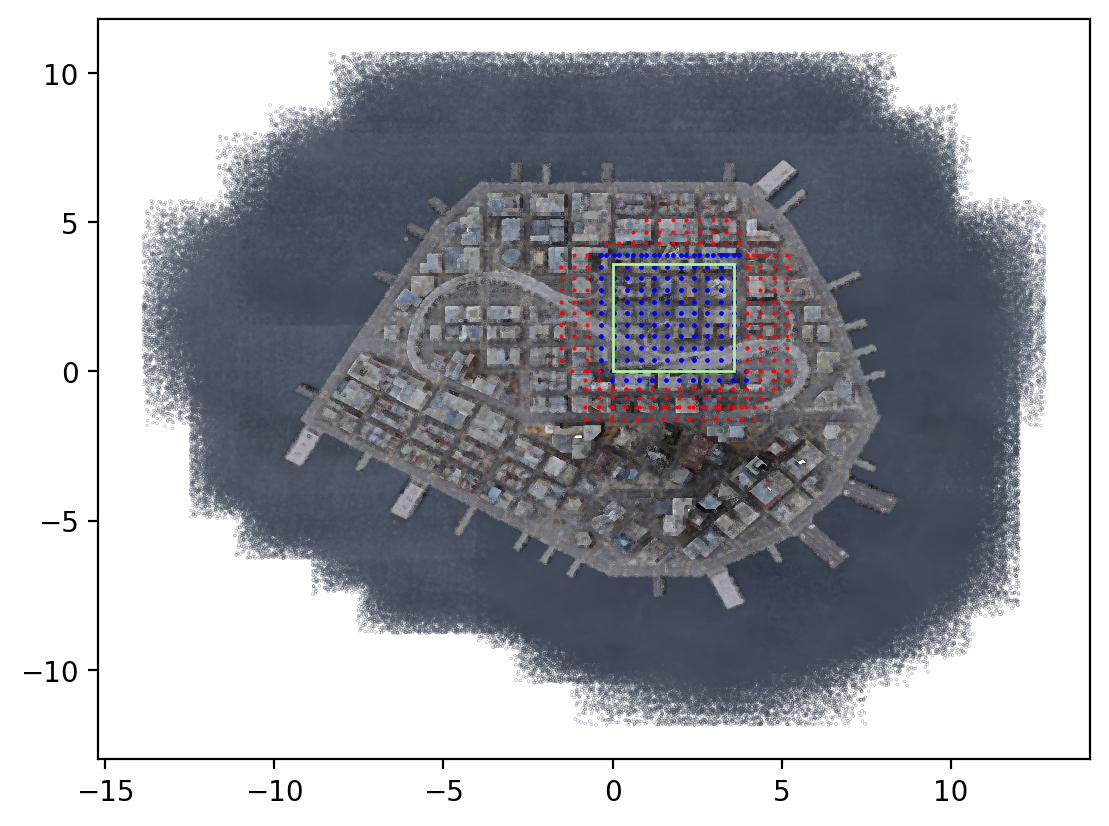

In [33]:
fig, ax = plt.subplots()
ax.scatter(point_cloud.xyz[:, 0], point_cloud.xyz[:, 1], c=point_cloud.rgb[:] / 255., s=0.01)
ax.scatter(
    train_camera_centers[is_image_in_partition_mask_list[target_partition_idx], 0],
    train_camera_centers[is_image_in_partition_mask_list[target_partition_idx], 1],
    s=0.2,
    c="blue",
)
ax.scatter(
    train_camera_centers[is_image_see_partition_mask_list[target_partition_idx], 0],
    train_camera_centers[is_image_see_partition_mask_list[target_partition_idx], 1],
    s=0.2,
    c="red",
)

ax.add_artist(mpatches.Rectangle(
    (partition_xys[target_partition_idx][0], partition_xys[target_partition_idx][1]),
    2 * partition_radius,
    2 * partition_radius,
    fill=False,
    color=colors[target_partition_idx],
))
# ax.annotate("({}, {})".format(*partition_grid_xy[target_partition_idx]),
#             xy=(i[0] + 0.25 * partition_radius, i[1] + 0.25 * partition_radius), fontsize=6)

plt.show()

In [46]:
torch.tensor([-6., -6.]) / (2 * partition_radius)

tensor([-1.6666667461395264, -1.6666667461395264])